In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('../')
import torch
import torch.nn as nn
import torch.optim as optim
from network.gap_layers import *
from datasets.datasets_pair import *
import functools
from network.sym_v1 import *
from network.flownet3d import *
from network.gpv_layers import *
from loss.utils import *
from visu.utils import *
from network.utils import *
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
from network.GPVNet import *

In [7]:
root_dir = "/16T/zhangran/GAPartNet_fix_small/train"
test_intra_dir = "/16T/zhangran/GAPartNet_fix_small/test_intra"
test_inter_dir = "/16T/zhangran/GAPartNet_fix_small/test_inter"

In [8]:
dataset_train, dataset_test_intra, dataset_test_inter = get_datasets(root_dir, test_intra_dir, test_inter_dir, voxelization=False, shot=False, choose_category=None, max_points=20000, augmentation=False, with_pose=True, no_ball_space=True)
dataloader_train, dataloader_test_intra, dataloader_test_inter = get_dataloaders(dataset_train, dataset_test_intra, dataset_test_inter, num_workers=0, batch_size=8)
print(len(dataset_train), len(dataset_test_intra), len(dataset_test_inter))

872 28 905


index:  534


names:  StorageFurniture_35059_0_31  and  StorageFurniture_35059_0_4
rot1:  tensor([[-1.1921e-07, -5.7358e-01,  8.1915e-01],
        [-1.0000e+00,  1.1921e-07,  0.0000e+00],
        [ 0.0000e+00, -8.1915e-01, -5.7358e-01]])
rot2:  tensor([[-1.1921e-07, -5.7358e-01,  8.1915e-01],
        [-1.0000e+00,  1.1921e-07,  0.0000e+00],
        [ 0.0000e+00, -8.1915e-01, -5.7358e-01]])


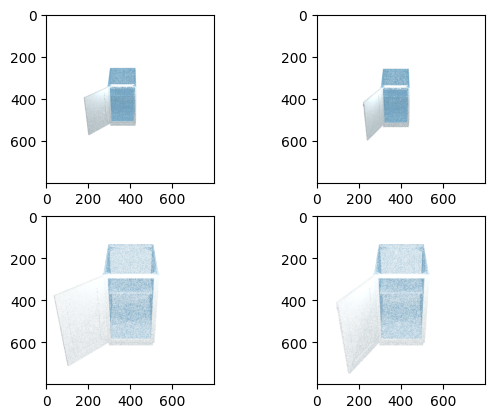

In [9]:
import visu.utils as u
import importlib
importlib.reload(u)
i = None
dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
u.show_datasets_pair(root_dir, dataset_train, None, False)

In [10]:
gpv_net = GPVNet().cuda()
gpv_net.load_state_dict(torch.load("../checkpoints/gpvnet.pth"))
gpv_net.eval()

flownet = FlowNet3D().cuda()
flownet.load_state_dict(torch.load("../checkpoints/flownet.pth"))
flownet.eval()

FlowNet3D(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(6, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2_convs): ModuleList()
    (queryandgroup): QueryAndGroup()
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

gpv_net is None, no rotation prediction


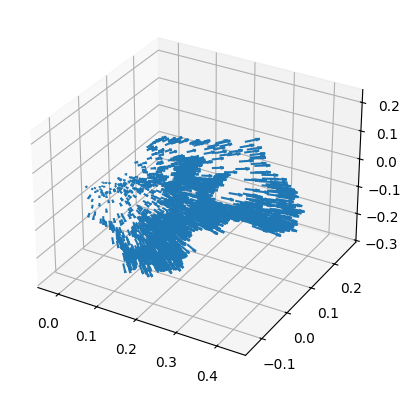

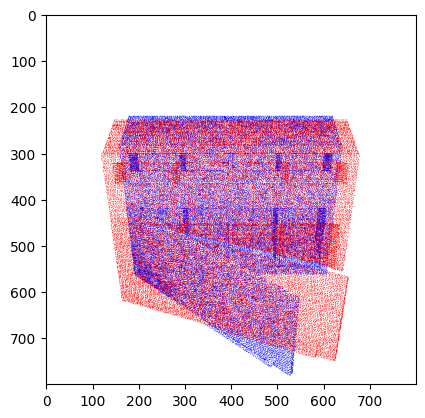

In [12]:
import visu.utils as u
import importlib
importlib.reload(u)

dir_name = {
    dataset_train: root_dir,
    dataset_test_inter: test_inter_dir,
    dataset_test_intra: test_intra_dir
}
log_name = {
    dataset_train: "train",
    dataset_test_inter: "inter",
    dataset_test_intra: "intra"
}
u.random_show_flow(None, flownet, dataset_train, dir_name, use_gt=False)

In [15]:
pc_pair.t1

tensor([-3.8091e+00,  4.6647e-16,  2.6671e+00])

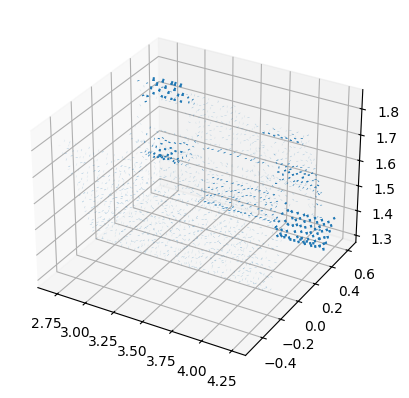

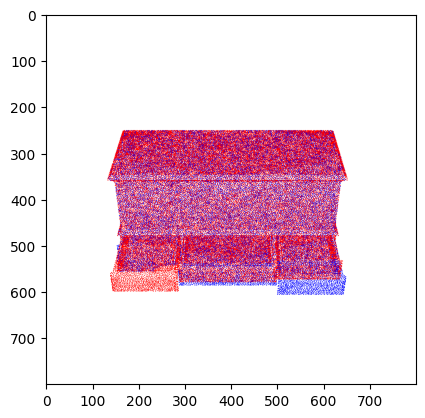

In [21]:
import visu.utils as u
import importlib
importlib.reload(u)
# i = random.randint(0, len(dataset_train))
i = 546
pc_pair = dataset_train[i]
points_input1 = pc_pair.pc1.points
points_input2 = pc_pair.pc2.points
trans1 = torch.cat((pc_pair.s1.unsqueeze(0), pc_pair.t1), dim=0).numpy()
trans2 = torch.cat((pc_pair.s2.unsqueeze(0), pc_pair.t2), dim=0).numpy()
u.random_show_fixed_camera(points_input1, points_input2, flownet=None, use_origin_color=False, add_flow=False, directly_nn=True, trans=trans1)

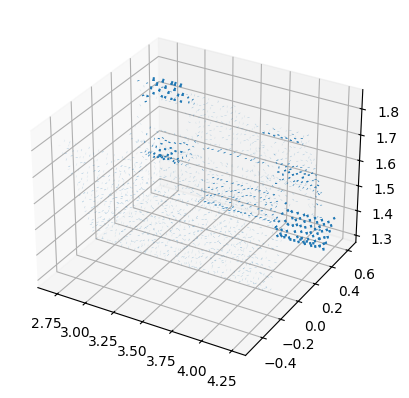

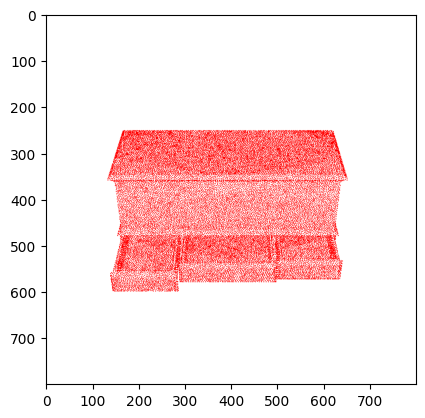

In [20]:
import visu.utils as u
import importlib
importlib.reload(u)
# i = random.randint(0, len(dataset_train))
i = 546
pc_pair = dataset_train[i]
points_input1 = pc_pair.pc1.points
points_input2 = pc_pair.pc2.points
trans1 = torch.cat((pc_pair.s1.unsqueeze(0), pc_pair.t1), dim=0).numpy()
trans2 = torch.cat((pc_pair.s2.unsqueeze(0), pc_pair.t2), dim=0).numpy()
u.random_show_fixed_camera(points_input1, points_input2, flownet=None, use_origin_color=False, add_flow=True, directly_nn=True, trans=trans1)